## Scanner template

This notebook contains the basic syntax required to run a chi2 scan

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
import scipy
# our own modules
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.emulator import p1d_archive_Nyx
from lace_manager.data import data_MPGADGET
from lace_manager.likelihood import lya_theory
from lace_manager.likelihood import likelihood
from lace_manager.sampler import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
use_nyx=True
if use_nyx:
    start=time.time()
    fname='/Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/large_nyx_models.hdf5'
    archive=p1d_archive_Nyx.archiveP1D_Nyx(fname=fname,verbosity=1)
    paramList=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p']
    end=time.time()
    print('{:.4f} seconds to setup Nyx archive'.format(end-start))
else:
    archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)
    paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']

will read Nyx file /Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/large_nyx_models.hdf5
number of samples 14
parameter names ['A_UVB', 'A_lya', 'A_s', 'H_0', 'Omega_m', 'h', 'n_lya', 'n_s', 'omega_m', 'sigma8']
will use redshift grid [2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 5.0, 5.4]
thermal grid ['thermal_grid_0', 'thermal_grid_1', 'thermal_grid_10', 'thermal_grid_11', 'thermal_grid_12', 'thermal_grid_13', 'thermal_grid_14', 'thermal_grid_2', 'thermal_grid_3', 'thermal_grid_4', 'thermal_grid_5', 'thermal_grid_6', 'thermal_grid_7', 'thermal_grid_8', 'thermal_grid_9']
archive setup, containing 3150 entries
93.9216 seconds to setup Nyx archive


In [5]:
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir=None,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 3150 points
GPs optimised in 94.96 seconds


### Specify free likelihood parameters in minimization (IGM only)

In [6]:
#free_param_names=["ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1"]
free_param_names=["ln_tau_0","ln_tau_1","ln_sigT_kms_0"]
#free_param_names=["ln_tau_0"]
prior=0.5

### Define fiducial cosmology to set new cosmologies for each pair of (Delta2_star, n_star)

In [7]:
cosmo_fid=camb_cosmo.get_cosmology()
fid_info={}
fid_info['As']=cosmo_fid.InitPower.As
fid_info['ns']=cosmo_fid.InitPower.ns
ks_Mpc=cosmo_fid.InitPower.pivot_scalar

In [8]:
z_star=3
kp_kms=0.009
camb_results_fid=camb_cosmo.get_camb_results(cosmo_fid,zs=[z_star])
linP_params_fid=fit_linP.parameterize_cosmology_kms(cosmo=cosmo_fid,
                        camb_results=camb_results_fid,z_star=z_star,kp_kms=kp_kms)
fid_info['Delta2_star']=linP_params_fid['Delta2_star']
fid_info['n_star']=linP_params_fid['n_star']
print(fid_info)

{'As': 2.1e-09, 'ns': 0.965, 'Delta2_star': 0.36031520035842585, 'n_star': -2.2995735858530693}


In [9]:
H_star=camb_results_fid.hubble_parameter(z_star)
dkms_dMpc=H_star/(1+z_star)
kp_Mpc=kp_kms*dkms_dMpc
print('kp_Mpc',kp_Mpc)
ln_kp_ks=np.log(kp_Mpc/ks_Mpc)
print('ln_kp_ks',ln_kp_ks)

kp_Mpc 0.6900412049263259
ln_kp_ks 2.6247283076646832


In [10]:
def get_max_log_like(fid_info,Delta2_star,n_star,debug=False):
    ns=fid_info['ns']+(n_star-fid_info['n_star'])
    ln_ratio_As=np.log(Delta2_star/fid_info['Delta2_star'])-(n_star-fid_info['n_star'])*ln_kp_ks
    As=fid_info['As']*np.exp(ln_ratio_As)
    
    cosmo_fid=camb_cosmo.get_cosmology(As=As,ns=ns)
    if debug:
        camb_cosmo.print_info(cosmo_fid)
        camb_results=camb_cosmo.get_camb_results(cosmo_fid,zs=[z_star])
        linP_params=fit_linP.parameterize_cosmology_kms(cosmo=cosmo_fid,
                    camb_results=camb_results,z_star=z_star,kp_kms=kp_kms)
        print(Delta2_star,linP_params['Delta2_star'])
        print(n_star,linP_params['n_star'])
    
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_fid)
    like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior,include_CMB=False)
    minimizer = iminuit_minimizer.IminuitMinimizer(like,print_level=0)
    minimizer.minimize(compute_hesse=False)
    return -minimizer.minimizer.fval

In [11]:
start=time.time()
get_max_log_like(fid_info,Delta2_star=0.35,n_star=-2.31,debug=True)
end=time.time()
print('{:.4f} seconds for a likelihood evaluation'.format(end-start))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0965E-09, n_s = 9.5457E-01, alpha_s = 0.0000E+00
0.35 0.3499999999999992
-2.31 -2.3100000000000005
6.7196 seconds for a likelihood evaluation


In [12]:
scan_N=10
min_Delta2_star=0.32
max_Delta2_star=0.38
min_n_star=-2.32
max_n_star=-2.28
Nj=complex(0,scan_N)
scan_Delta2_star, scan_n_star = np.mgrid[min_Delta2_star:max_Delta2_star:Nj, min_n_star:max_n_star:Nj]
scan_log_like = np.empty_like(scan_Delta2_star)

In [13]:
start = time.time()
for i in range(scan_N):
    for j in range(scan_N):
        Delta2_star=scan_Delta2_star[i,j]
        n_star=scan_n_star[i,j]
        scan_log_like[i,j]=get_max_log_like(fid_info,Delta2_star=Delta2_star,n_star=n_star)
    end=time.time()
    print('{:.4f} seconds to run {} / {} minimizations'.format(end-start,(i+1)*scan_N,scan_N*scan_N))
end = time.time()
print('{:.4f} seconds to run the scan'.format(end-start))

91.8608 seconds to run 10 / 100 minimizations
166.1211 seconds to run 20 / 100 minimizations
261.0615 seconds to run 30 / 100 minimizations
353.7901 seconds to run 40 / 100 minimizations
411.1188 seconds to run 50 / 100 minimizations
464.0970 seconds to run 60 / 100 minimizations
515.8405 seconds to run 70 / 100 minimizations
563.8496 seconds to run 80 / 100 minimizations
611.6882 seconds to run 90 / 100 minimizations
660.5030 seconds to run 100 / 100 minimizations
660.5033 seconds to run the scan


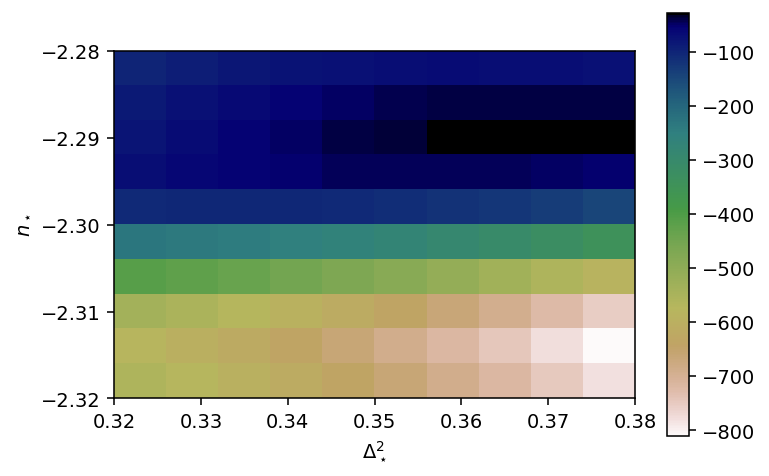

In [14]:
max_log_like=np.max(scan_log_like)
prob=np.exp(scan_log_like-max_log_like)
plt.imshow(np.rot90(scan_log_like), cmap=plt.cm.gist_earth_r,
           extent=[min_Delta2_star, max_Delta2_star, min_n_star, max_n_star])
plt.xlabel(r'$\Delta^2_\star$')
plt.ylabel(r'$n_\star$')
plt.colorbar()

### Write / read scan to / from file

In [15]:
fname='test_scan.npz'
np.savez(fname,Delta2_star=np.unique(scan_Delta2_star),n_star=np.unique(scan_n_star),log_like=scan_log_like)

In [16]:
# open binary file
scan_data = np.load(fname)
# read 2D grid of parameters and log_like scan
Delta2_star=scan_data['Delta2_star']
n_star=scan_data['n_star']
log_like=scan_data['log_like']
max_log_like=np.max(log_like)
log_like-=max_log_like
# setup interpolator for normalised log likelihood
log_like_interp=scipy.interpolate.RectBivariateSpline(Delta2_star,n_star,log_like)

### Plot log_like scan using interpolation

In [17]:
scan_N=200
min_Delta2_star=np.min(Delta2_star)
max_Delta2_star=np.max(Delta2_star)
min_n_star=np.min(n_star)
max_n_star=np.max(n_star)
Nj=complex(0,scan_N)
X,Y = np.mgrid[min_Delta2_star:max_Delta2_star:Nj, min_n_star:max_n_star:Nj]
Z = np.empty_like(X)
for ix in range(scan_N):
    for iy in range(scan_N):
        Z[ix,iy] = log_like_interp.ev(X[ix,iy],Y[ix,iy])

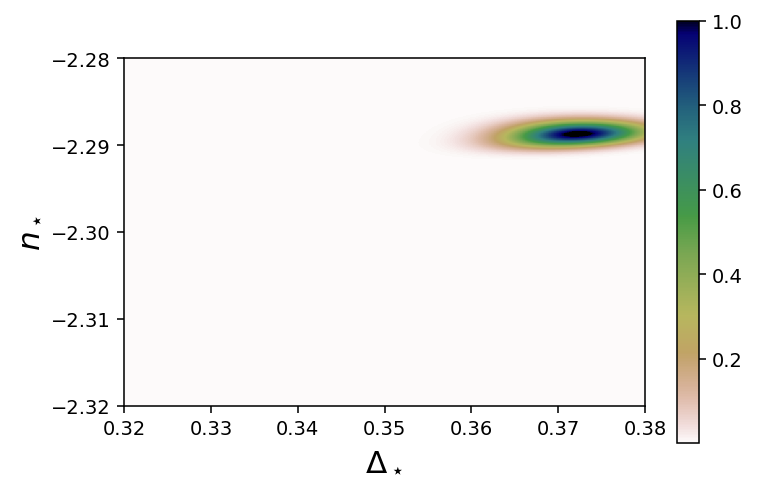

In [18]:
prob=np.exp(Z)
min_prob=0.0001
cmap=plt.cm.gist_earth_r
extent=[min_Delta2_star,max_Delta2_star,min_n_star,max_n_star]
plt.imshow(np.rot90(prob),cmap=cmap,extent=extent,vmin=min_prob,vmax=1.0)
plt.xlabel(r'$\Delta_\star$',fontsize=16)
plt.ylabel(r'$n_\star$',fontsize=16)
plt.colorbar()